## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [1]:
import openeo
from extractor import load_input_WAC
from inference import inference_WAC


CRS = "EPSG:3035"
RESOLUTION = 10  # important; the resolution is implicitely tied to the CRS; so we need to use UTM based CRS here

SPATIAL_EXTENT = {
    'west': 300000,
    'south': 9800000,
    'east': 305000,  
    'north': 9805000,  
    'crs': CRS  
}

TEMPORAL_EXTENT = ['2023-06-01', '2023-08-01'] #Sentinel 1 mosiac needs a buffer of 1 day, here processing for january
MAX_CLOUD_COVER = 85

JOB_OPTIONS = {'driver-memory': '1000m',
 'driver-memoryOverhead': '1000m',
 'executor-memory': '1500m',
 'executor-memoryOverhead': '1500m',
 'python-memory': '8000m',
 'max-executors': 20,
 "udf-dependency-archives": [
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_dependencies_1.16.3.zip#onnx_deps",
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/WAC_model_hansvrp.zip#onnx_models"
        ]
 }




In [ ]:

connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

input_cube = load_input_WAC(connection, SPATIAL_EXTENT, TEMPORAL_EXTENT, MAX_CLOUD_COVER, RESOLUTION, CRS)

inference_cube = inference_WAC(input_cube)

save_cube = inference_cube.save_result(format = "netCDF")
job = connection.create_job([save_cube],
    additional=JOB_OPTIONS
)

job.start_and_wait()



Authenticated using refresh token.
0:00:00 Job 'j-2505231742074554a2f46236ca78af7b': send 'start'
0:00:13 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:00:19 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:00:25 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:00:33 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:00:43 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:00:56 Job 'j-2505231742074554a2f46236ca78af7b': created (progress 0%)
0:01:11 Job 'j-2505231742074554a2f46236ca78af7b': running (progress N/A)


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

results = job.get_results()
results.download_files("C:/Git_projects/WAC/production/prediction/test5")

# Open the NetCDF file
ds = xr.open_dataset(r'C:\Git_projects\WAC\production\prediction\test5\openEO.nc')



ChunkedEncodingError: ('Connection broken: IncompleteRead(2621050 bytes read, 51662055 more expected)', IncompleteRead(2621050 bytes read, 51662055 more expected))

In [ ]:
print(ds)

<xarray.Dataset> Size: 88MB
Dimensions:         (t: 2, x: 500, y: 500)
Coordinates:
  * t               (t) datetime64[ns] 16B 2023-06-01 2023-07-01
  * x               (x) float64 4kB 3e+05 3e+05 3e+05 ... 3.05e+05 3.05e+05
  * y               (y) float64 4kB 9.805e+06 9.805e+06 ... 9.8e+06 9.8e+06
Data variables: (12/23)
    crs             |S1 1B ...
    prediction      (t, y, x) float64 4MB ...
    unkown_band_1   (t, y, x) float64 4MB ...
    unkown_band_2   (t, y, x) float64 4MB ...
    unkown_band_3   (t, y, x) float64 4MB ...
    unkown_band_4   (t, y, x) float64 4MB ...
    ...              ...
    unkown_band_16  (t, y, x) float64 4MB ...
    unkown_band_17  (t, y, x) float64 4MB ...
    unkown_band_18  (t, y, x) float64 4MB ...
    unkown_band_19  (t, y, x) float64 4MB ...
    unkown_band_20  (t, y, x) float64 4MB ...
    unkown_band_21  (t, y, x) float64 4MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.66.0a3.dev2

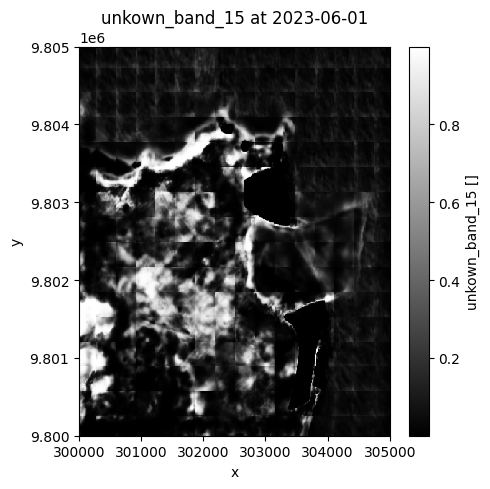

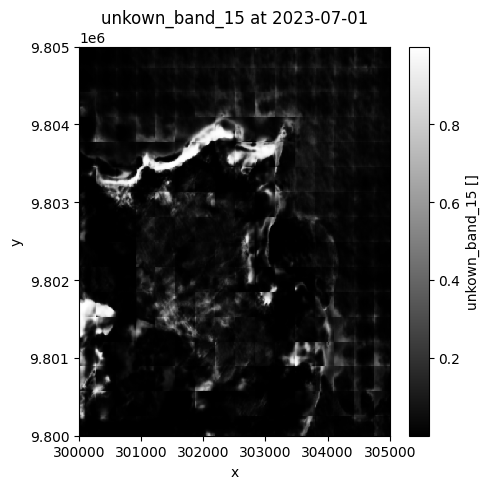

In [ ]:
band_name = 'unkown_band_15'  # or 'unknown_band_1'

# Loop through each timestep
for i, t in enumerate(ds['t']):
    fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

    band = ds[band_name].sel(t=t)
    band.plot(ax=ax, cmap='grey')
    
    ax.set_title(f'{band_name} at {str(t.values)[:10]}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np

def gaussian_kernel(k:int, sigma:float) -> np.ndarray:
    """Return a k×k Gaussian kernel with standard deviation sigma."""
    assert k % 2 == 1, "Kernel size k must be odd"
    ax = np.arange(-(k//2), k//2 + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= kernel.sum()
    return kernel

kernel_array = gaussian_kernel(k=5, sigma=1.0)
kernel_list = kernel_array.tolist()

# 4. apply the kernel
smoothed = inference_cube.apply_kernel(
    kernel=kernel_list,
    factor=1.0,                # already normalized
    border={"mode": "mirror"}, # how to handle edges
    dimension=["x", "y"]       # apply spatially
)

save_cube = smoothed.save_result(format = "netCDF")


job = connection.create_job([save_cube],
    additional=JOB_OPTIONS
)

job.start_and_wait()